# Reading the ROOT files

In [805]:
# exec(open("./do_imports.py").read())

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

In [806]:
from torch_geometric.utils import from_networkx, add_self_loops
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import GCNConv, ASAPooling, TopKPooling
from torch.nn import Linear, Sequential, ReLU, Dropout, Sigmoid
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx

In [807]:
from evaluate_results import *
# from batched_data import *
# import cnn_batched_data
from tqdm import tqdm

In [808]:
from data.data_preprocessing import *

In [809]:
import pandas as pd

In [810]:
from GCN_utils import *

In [811]:
all_rates = load_obj('all_rates', directory='./')
results = dict()


## Get sets of data for only dineutron cases

In [812]:
class GCNNet(torch.nn.Module):
    def __init__(self, final_out=3, n_pmts=2330):
        super(GCNNet, self).__init__()
        self.lin = Sequential(Linear(n_pmts*final_out, 32),
                              nn.BatchNorm1d(32),
                              ReLU(), 
                              Linear(32, 1),
                             )
        self.conv1 = GCNConv(5, 32)
        self.conv2 = GCNConv(32, 16)
        self.conv3 = GCNConv(16, final_out)
        self.final_out=final_out
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index,)
        x = F.relu(x)
        x = self.conv2(x, edge_index,)
        x = F.relu(x)
        x = self.conv3(x, edge_index,)
        x = F.relu(x)
        x = x.view(-1, self.final_out*n_pmts)
        x = self.lin(x)
        return x
        return x


In [813]:
torch.cuda.set_device(1)
device = torch.device("cuda")

In [814]:
tgkw = dict(medium='wbls', max_dist=600.0, min_dist=0.,)
torch_graph = get_graph(**tgkw # max is 1584 cm 
)
n_pmts = len(torch_graph.pos)
model = GCNNet(n_pmts=n_pmts).to(device)

***Creating Graph...***
***Graph Created...***


In [815]:
statedict = torch.load('GCN_models/model_wbls.pkl')

In [816]:
torch.cuda.empty_cache() 

In [817]:
model.load_state_dict(statedict)
model.eval()

GCNNet(
  (lin): Sequential(
    (0): Linear(in_features=3696, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
  (conv1): GCNConv(5, 32)
  (conv2): GCNConv(32, 16)
  (conv3): GCNConv(16, 3)
)

In [818]:
def get_gcn_predictions(model, datagen, device='cpu'):
    model.eval()
    correct = 0.0
    loss = 0.0
    totsize = len(datagen.y)
    net_out = torch.zeros((len(datagen.y),1))
    batch_size=datagen.batch_size
    with tqdm(datagen, unit="batch") as tepoch:
        tepoch.set_description(f'Validating..')
        for i, data in enumerate(tepoch):
            inputs = data.to(device)
            outputs = torch.sigmoid(model(inputs).detach())
            net_out[i*batch_size:(i+1)*batch_size] = outputs
    del inputs, outputs
    return net_out

### Prep data for model input

In [819]:
val = GCNSeq('test_wbls_2sig', torch_graph, shuffle=False, batch_size=12)
train = GCNSeq('train_wbls_2sig', torch_graph, shuffle=False, batch_size=12)

## Create function to return only true 2-signal data

In [820]:
gcn_out_test = get_gcn_predictions(model, val, device=device)
gcn_out_train =  get_gcn_predictions(model, train, device=device)

Validating..: 100%|██████████| 444/444 [00:21<00:00, 20.33batch/s]


In [821]:
gcn_scores = np.asarray(gcn_out_test[:,0])

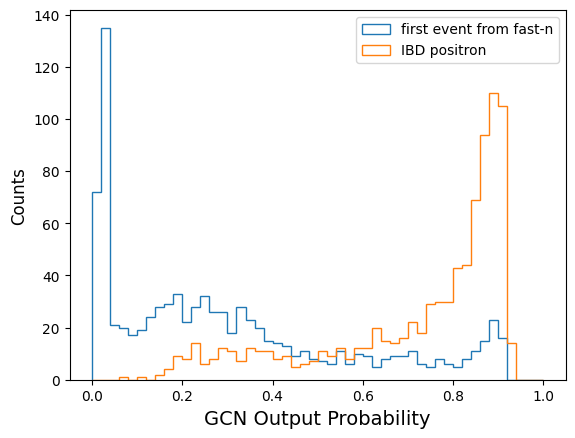

In [822]:
kw = dict(histtype='step', bins=50, range=[0,1])
kw = dict(histtype='step', bins=50, range=[0,1])
plt.hist(gcn_scores[val.y==0], **kw, label='first event from fast-n')
plt.hist(gcn_scores[val.y==1], **kw, label='IBD positron')
plt.xlabel('GCN Output Probability', fontsize=14)
plt.ylabel('Counts', fontsize=12)
# plt.yscale('log')
plt.legend()
plt.show()

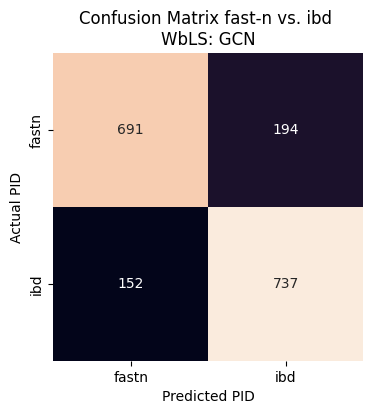

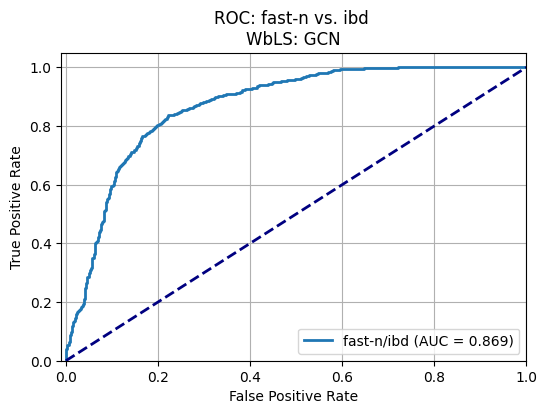

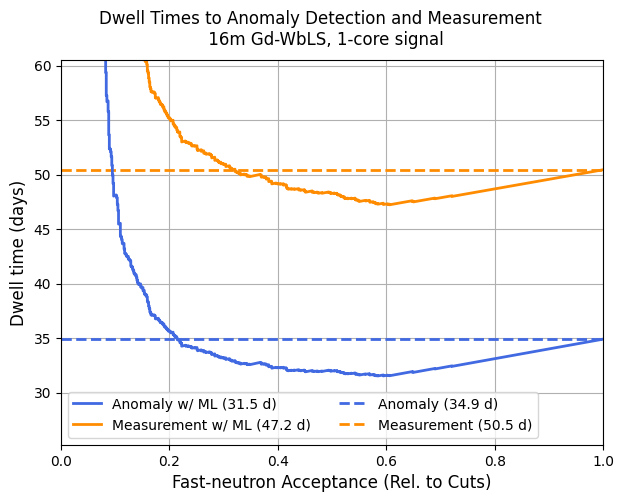

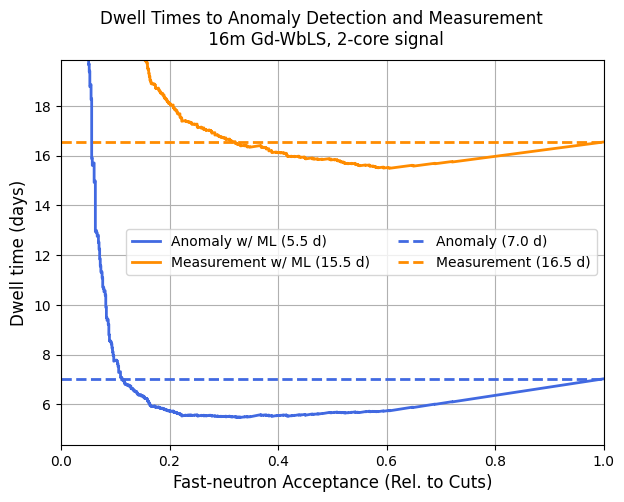

In [823]:
ml = ML_Evaluation(val.y, gcn_out_test)
ml.draw_confmat(extra_title='\nWbLS: GCN')
gcn_tpr, gcn_fpr, gcn_thresholds = ml.draw_roc(extra_title='\nWbLS: GCN')

gcn_acceptances = dict(fpr=gcn_fpr, tpr=gcn_tpr)
quick_analysis(gcn_acceptances, medium='wbls')

results['gcn'] = dict(scores=gcn_scores, tpr=gcn_tpr, fpr=gcn_fpr, thresholds=gcn_thresholds)

------

In [824]:
precision_recall_fscore_support(y_test, np.round(gcn_scores))

(array([0.81969158, 0.79162191]),
 array([0.78079096, 0.82902137]),
 array([0.79976852, 0.80989011]),
 array([885, 889]))

## Analyzing the bump of fast-neutrons: 

In [774]:
val.x['r'] = np.sqrt(val.x['x']**2 + val.x['y']**2)

In [775]:
ibdlike_fn_index =np.asarray(np.argwhere(np.logical_and(val.y==0, gcn_out_test[:,0]>0.5)))[0]

In [776]:
ibdlike_fn = val.x[ibdlike_fn_index]

In [777]:
allfastn = val.x[val.y==0]
allibd=val.x[val.y==1]

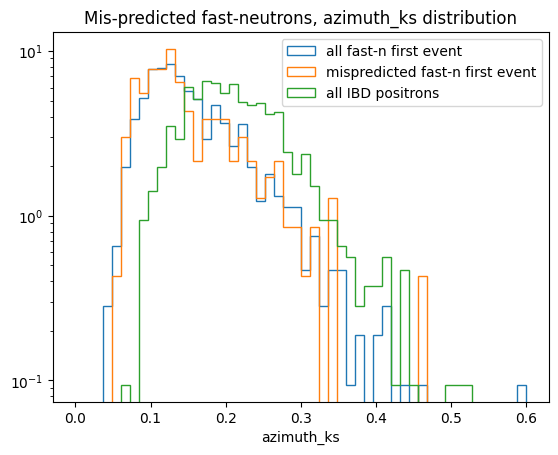

In [794]:
kw = dict(histtype='step', 
          range=[0,.6], 
          density=True)
key = 'azimuth_ks'
bins= plt.hist(allfastn[key], bins=50, label='all fast-n first event', **kw)
plt.hist(ibdlike_fn[key], bins=bins[1], label='mispredicted fast-n first event', **kw)
plt.hist(allibd[key], bins=bins[1], label='all IBD positrons', **kw)
plt.xlabel(key)
plt.title('Mis-predicted fast-neutrons, %s distribution'%(key))
plt.legend()
plt.yscale('log')
plt.show()

## Getting data in input form

Need to get those with a 1 for sure as it has a 0, then take those separated by the 0 or 1 

In [9]:
def get_scores(load_saved=False, save_these=False):
    if load_saved:
        rnn_out_test = np.loadtxt("testpreds.csv", delimiter=",", ndmin=2)
        rnn_out_train = np.loadtxt("trainpreds.csv", delimiter=",", ndmin=2)
    else: 
        rnn_out_test = model.predict(val, verbose=1)
        rnn_out_train = model.predict(train, verbose=1)
    if save_these:
        np.savetxt("testpreds.csv", rnn_out_test, delimiter=",")
        np.savetxt("trainpreds.csv", rnn_out_train, delimiter=",")
    
    return rnn_out_train, rnn_out_test

In [ ]:
plt.scatter(what, scores[:,1], s=5, c=y_test)
plt.show()

## Take RNN output and add to X1 (RF) data

In [825]:
dimensions = [
    'n9', 'n100', 'n400',
    'x', 'y', 'z', # 'r',
    'id_plus_dr_hit', 
    'good_dir', 
    'good_dir_next', # 'good_pos_next', 
    'good_pos',
    'closestPMT', 'closestPMT_next', # 'distpmt', 
    'drNextr', # 'dzNextz', 
     'dt_next_us', 
    'azimuth_ks',  'azimuth_ks_next',
    'n100_next','n9_next',
    'pe', 
#     'beta_four',
    'beta_one', 'beta_two', 'beta_three', 'beta_four', 'beta_five', 'beta_six',
]

In [826]:
X_train3, y_train, X_test3, y_test, sc = scale_features(train, val, dimensions)

Remaining variables selected for analysis: 25
Remaining variables selected for analysis: 25


In [827]:
new_train, new_test, yy_train, yy_test, dims_add = add_netoutput_to_rf(X_train3, X_test3, y_train, y_test, 
                                                            nn_out_train=None, nn_out_test=None, fred_dimensions=dimensions )

In [501]:
n_trees = np.array([20, 50, 100, 200])
max_depth = np.array([6, 8, 10, 12, 15])
min_per_leaf = np.array([2, 10, 50, 100])

In [502]:
train_acc_rf = np.zeros((len(n_trees), len(max_depth), len(min_per_leaf)))
test_acc_rf = np.zeros((len(n_trees), len(max_depth), len(min_per_leaf)))

In [503]:
for i, ntrees in enumerate(n_trees):
    for j, depthmax in enumerate(max_depth):
        for k, minsperleaf in enumerate(min_per_leaf):
            if train_acc_rf[i,j,k]>0:
                continue
            print(f'Calculating: n_bc={ntrees} max_depth:{depthmax} min_samples_per_leaf:{minsperleaf}')
            #Create a Gaussian Classifier
            rf=RandomForestClassifier(
                n_estimators=ntrees, 
                max_depth=depthmax, 
                min_samples_leaf=minsperleaf,
                bootstrap=True,
            )
            #Train the model using the training sets
            rf.fit(new_train,yy_train)
            train_acc_rf[i,j,k] = rf.score(new_train, y_train)
            test_acc_rf[i,j,k] = rf.score(new_test, y_test)
            print("Train Acc: %.4f"%(train_acc_rf[i,j,k]))
            print("Val.  Acc: %.4f"%(test_acc_rf[i,j,k]))

Calculating: n_bc=20 max_depth:6 min_samples_per_leaf:2
Train Acc: 0.9466
Val.  Acc: 0.9188
Calculating: n_bc=20 max_depth:6 min_samples_per_leaf:10
Train Acc: 0.9410
Val.  Acc: 0.9222
Calculating: n_bc=20 max_depth:6 min_samples_per_leaf:50
Train Acc: 0.9320
Val.  Acc: 0.9154
Calculating: n_bc=20 max_depth:6 min_samples_per_leaf:100
Train Acc: 0.9213
Val.  Acc: 0.9143
Calculating: n_bc=20 max_depth:8 min_samples_per_leaf:2
Train Acc: 0.9634
Val.  Acc: 0.9222
Calculating: n_bc=20 max_depth:8 min_samples_per_leaf:10
Train Acc: 0.9517
Val.  Acc: 0.9273
Calculating: n_bc=20 max_depth:8 min_samples_per_leaf:50
Train Acc: 0.9309
Val.  Acc: 0.9171
Calculating: n_bc=20 max_depth:8 min_samples_per_leaf:100
Train Acc: 0.9207
Val.  Acc: 0.9098
Calculating: n_bc=20 max_depth:10 min_samples_per_leaf:2
Train Acc: 0.9744
Val.  Acc: 0.9228
Calculating: n_bc=20 max_depth:10 min_samples_per_leaf:10
Train Acc: 0.9526
Val.  Acc: 0.9205
Calculating: n_bc=20 max_depth:10 min_samples_per_leaf:50
Train Acc: 

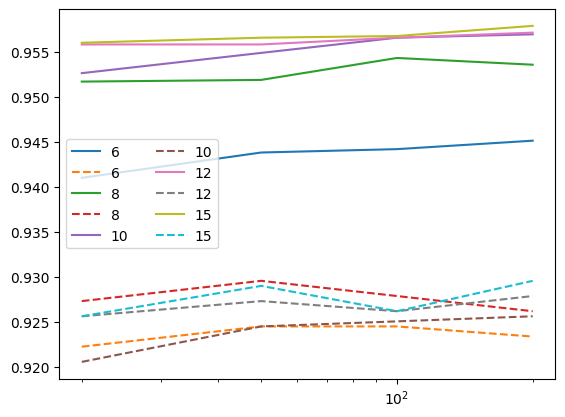

In [508]:
# print n trees vs. n_boost vs. accuracy 
plt.figure()
for i, depthmax in enumerate(max_depth):
    plt.plot(n_trees, train_acc_rf[:,i,1], label=depthmax)
    plt.plot(n_trees, test_acc_rf[:,i,1], label=depthmax, linestyle='--')
plt.xscale('log')
plt.legend(ncol=2)
plt.show()

In [828]:
# best_score = np.max(test_acc_rf)
# best_params = np.argwhere(test_acc_rf==best_score)[0]
# ntrees = n_trees[best_params[0]]
# depthmax = max_depth[best_params[1]]
# minperleaf = min_per_leaf[best_params[2]]

#Load up from last round to not rescan:
best_score = .92953
ntrees = 50
depthmax = 8
minperleaf = 10

In [829]:

print(f'Best Test Score:{best_score} n_trees={ntrees} depthmax={depthmax} minperleaf={minperleaf}')
rf=RandomForestClassifier(n_estimators=ntrees, 
    max_depth=depthmax, 
    bootstrap=True, min_samples_leaf=minperleaf,
)
rf.fit(new_train,yy_train)

Best Test Score:0.92953 n_trees=50 depthmax=8 minperleaf=10


RandomForestClassifier(max_depth=8, min_samples_leaf=10, n_estimators=50)

In [830]:
rf_feature_imp = pd.Series(rf.feature_importances_,index=dims_add).sort_values(ascending=False)

In [831]:
y_train_pred = rf.predict(new_train)
y_test_pred=rf.predict(new_test)
rf_scores = rf.predict_proba(new_test)

In [832]:
# Model Accuracy, how often is the classifier correct?
print("Train Accuracy: %.2f%%"%(metrics.accuracy_score(yy_train, y_train_pred)*100))
print("Test Accuracy: %.2f%%"%(metrics.accuracy_score(yy_test, y_test_pred)*100))

Train Accuracy: 95.32%
Test Accuracy: 92.28%


In [833]:
colordict = dict(
    n100 = 'red', pe = 'red', n9 = 'red', n400 = 'red', id_plus_dr_hit = 'red', 
    x = 'deepskyblue', y='deepskyblue', z='deepskyblue', u='deepskyblue', v='deepskyblue', w='deepskyblue', 
    closestPMT = 'deepskyblue', 
    azimuth_ks = 'orange', beta_one='orange', beta_two='orange', beta_three='orange', beta_four='orange', beta_five='orange', beta_six='orange', 
    closestPMT_next = 'hotpink', dt_next_us = 'hotpink', good_dir_next = 'hotpink', azimuth_ks_next = 'hotpink', 
    n9_next = 'hotpink', n100_next = 'hotpink', drNextr = 'hotpink', 
    good_pos = 'mediumseagreen', good_dir = 'mediumseagreen',
)
colors = [colordict[c] if c in colordict else 'k' for c in rf_feature_imp.index]

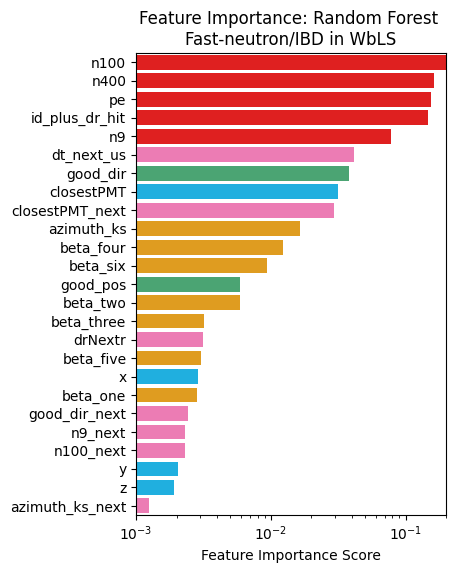

In [834]:
# Creating a bar plot
plt.figure(figsize=(4, 6))
ax = sns.barplot(x=rf_feature_imp, 
                 y=rf_feature_imp.index, 
                 palette = colors, 
                )

ax.yaxis.set_ticklabels(rf_feature_imp.index,)
plt.xlabel('Feature Importance Score')
plt.xscale('log')
plt.xlim(1e-3, .2)
# plt.ylabel('Features')
plt.title("Feature Importance: Random Forest \nFast-neutron/IBD in WbLS")
plt.show()

In [835]:
results['rf'] = dict(scores=rf_scores, tpr=rf_tpr, fpr=rf_fpr, thresholds=rf_thresholds)

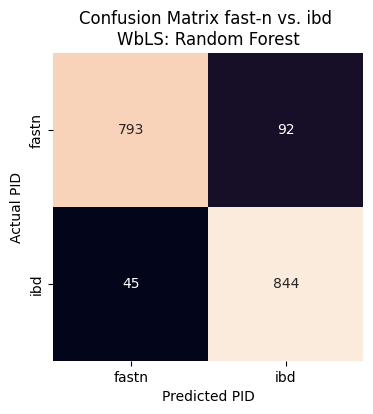

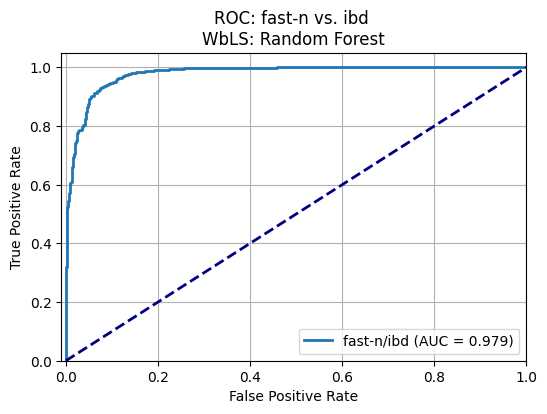

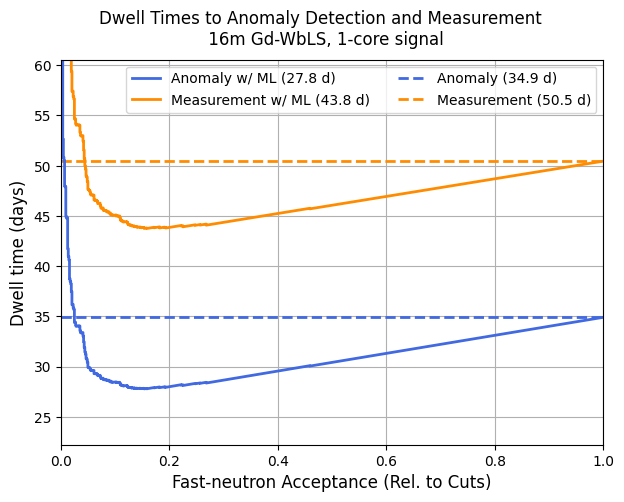

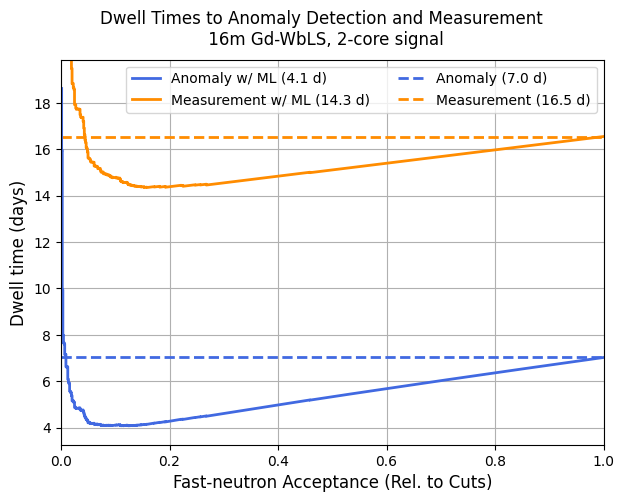

In [836]:
ml = ML_Evaluation(y_test, rf_scores)
ml.draw_confmat(extra_title='\nWbLS: Random Forest')
rf_tpr, rf_fpr, rf_thresholds = ml.draw_roc(extra_title='\nWbLS: Random Forest')

acceptances = dict(fpr=rf_fpr, tpr=rf_tpr)
# save_obj(acceptances, 'rates')
quick_analysis(acceptances, medium='wbls')

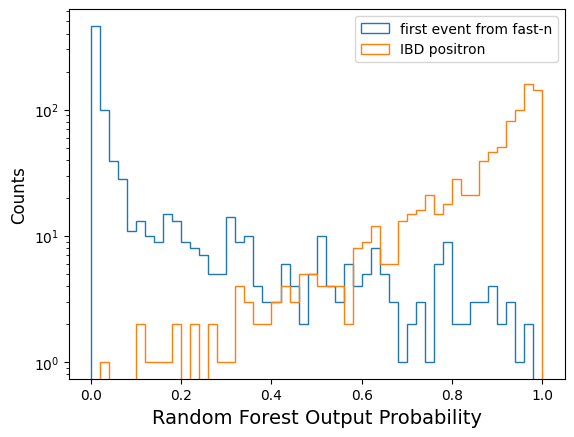

In [837]:
kw = dict(histtype='step', bins=50, range=[0,1])
plt.hist(rf_scores[:,1][val.y==0], **kw, label='first event from fast-n')
plt.hist(rf_scores[:,1][val.y==1], **kw, label='IBD positron')
plt.xlabel('Random Forest Output Probability', fontsize=14)
plt.ylabel('Counts', fontsize=12)
plt.yscale('log')
plt.legend()
plt.show()

In [838]:
precision_recall_fscore_support(y_test, np.round(rf_scores[:,1]))

(array([0.94630072, 0.9017094 ]),
 array([0.8960452 , 0.94938133]),
 array([0.92048752, 0.92493151]),
 array([885, 889]))

## Trying more rigorous AdaBoost

In [528]:
n_trees = np.array([1, 2, 5, 10, 20, 50, 100])
max_depth = np.array([2, 4, 6, 8])
min_per_leaf = np.array([1, 10, 100])
n_boost = np.array([5, 10, 15, 20, 50, 100])

In [441]:
train_acc_bf = np.zeros((len(n_trees), len(max_depth), len(min_per_leaf), len(n_rfs), ))
test_acc_bf = np.zeros((len(n_trees), len(max_depth), len(min_per_leaf), len(n_rfs), ))

In [464]:
for i, ntrees in enumerate(n_trees):
    for j, depthmax in enumerate(max_depth):
        for k, minsperleaf in enumerate(min_per_leaf):
            for l, nboost in enumerate(n_boost):
                if train_acc_bf[i,j,k,l]>0:
                    continue
                print(f'Calculating: n_bc={ntrees} max_depth:{depthmax} min_samples_per_leaf:{minsperleaf} num boosts:{nboost}')
                clf=RandomForestClassifier(n_estimators=ntrees, 
                    max_depth=depthmax, 
                    bootstrap=True, min_samples_leaf=minsperleaf,
                )
                bf = AdaBoostClassifier(base_estimator=clf, n_estimators=nboost, random_state=43)
                bf.fit(new_train,yy_train)
                train_acc_bf[i,j,k,l] = bf.score(new_train, y_train)
                test_acc_bf[i,j,k,l] = bf.score(new_test, y_test)
                print("Train Acc: %.4f"%(train_acc_bf[i,j,k,l]))
                print("Val.  Acc: %.4f"%(test_acc_bf[i,j,k,l]))

Calculating: n_bc=1 max_depth:2 min_samples_per_leaf:1 num boosts:5
Train Acc: 0.9139
Val.  Acc: 0.8974
Calculating: n_bc=1 max_depth:2 min_samples_per_leaf:1 num boosts:10
Train Acc: 0.9226
Val.  Acc: 0.8963
Calculating: n_bc=1 max_depth:2 min_samples_per_leaf:1 num boosts:15
Train Acc: 0.9288
Val.  Acc: 0.9019
Calculating: n_bc=1 max_depth:2 min_samples_per_leaf:1 num boosts:20
Train Acc: 0.9312
Val.  Acc: 0.9064
Calculating: n_bc=1 max_depth:2 min_samples_per_leaf:1 num boosts:50
Train Acc: 0.9260
Val.  Acc: 0.8816
Calculating: n_bc=1 max_depth:2 min_samples_per_leaf:1 num boosts:100
Train Acc: 0.9433
Val.  Acc: 0.8799
Calculating: n_bc=1 max_depth:2 min_samples_per_leaf:10 num boosts:5
Train Acc: 0.9136
Val.  Acc: 0.8980
Calculating: n_bc=1 max_depth:2 min_samples_per_leaf:10 num boosts:10
Train Acc: 0.9243
Val.  Acc: 0.8991
Calculating: n_bc=1 max_depth:2 min_samples_per_leaf:10 num boosts:15
Train Acc: 0.9331
Val.  Acc: 0.8997
Calculating: n_bc=1 max_depth:2 min_samples_per_leaf:

KeyboardInterrupt: 

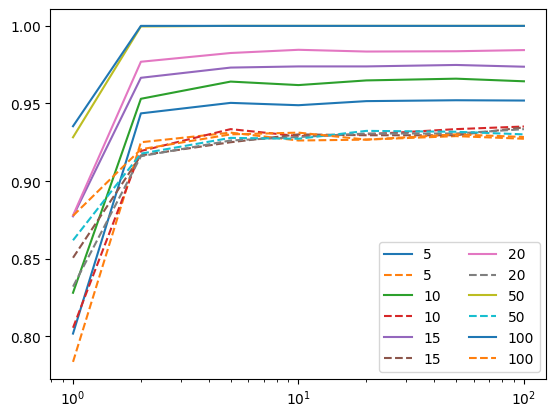

In [469]:
# print n trees vs. n_boost vs. accuracy 
plt.figure()
for l, nboost in enumerate(n_boost):
    plt.plot(n_trees, train_acc_bf[:,1,1,l], label=nboost)
    plt.plot(n_trees, test_acc_bf[:,1,1,l], label=nboost, linestyle='--')
plt.xscale('log')
plt.legend(ncol=2)
plt.show()

In [839]:
# best_score = np.max(test_acc_bf)
# best_params = np.argwhere(test_acc_bf==best_score)[0]
# ntrees = n_trees[best_params[0]]
# depthmax = max_depth[best_params[1]]
# minperleaf = min_per_leaf[best_params[2]]
# nboost = n_boost[best_params[3]]

#loadup since we already scanned and know 
best_score = .936865
ntrees=50
depthmax=6
minperleaf=100
nboost=10

In [840]:

print(f'Best Test Score:{best_score} n_trees={ntrees} depthmax={depthmax} minperleaf={minperleaf} nboost={nboost}')
clf=RandomForestClassifier(n_estimators=ntrees, 
    max_depth=depthmax, 
    bootstrap=True, min_samples_leaf=minperleaf,
)
bf = AdaBoostClassifier(base_estimator=clf, n_estimators=nboost, random_state=43)
bf.fit(new_train,yy_train)

Best Test Score:0.936865 n_trees=50 depthmax=6 minperleaf=100 nboost=10


AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=6,
                                                         min_samples_leaf=100,
                                                         n_estimators=50),
                   n_estimators=10, random_state=43)

In [841]:
print(bf.score(new_train, y_train))
print(bf.score(new_test, y_test))

0.969184517098835
0.9368658399098083


In [842]:
bf_scores = bf.predict_proba(new_test)

In [844]:
bf_prob = np.asarray(bf_scores[:,1])

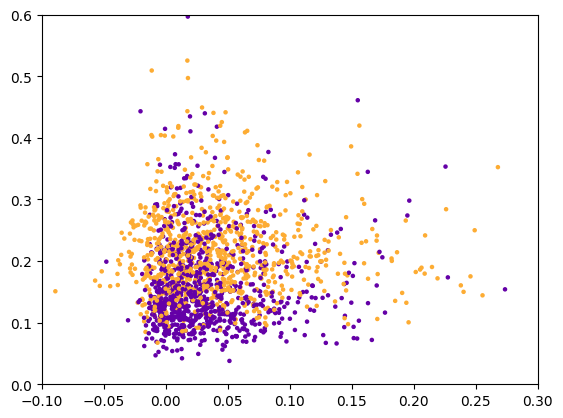

In [ ]:
x = new_test['beta_one']
y = new_test['azimuth_ks']
plt.figure()
plt.subplot(111)
plot_step=50
x_min, x_max = x.min() - 1, x.max() + 1
y_min, y_max = y.min() - 1, y.max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = bf.predict(new_test)
# Z = Z.reshape(xx.shape)
# cs = plt.contourf(x, y, Z, cmap=plt.cm.Paired)
plt.scatter(x, y, c=Z, cmap=plt.cm.plasma, vmin=-0.3, vmax=1.3, s=5)
# plt.contour()
plt.axis("tight")

plt.xlim(-0.1, 0.3)
plt.ylim(0, .6)
plt.show()

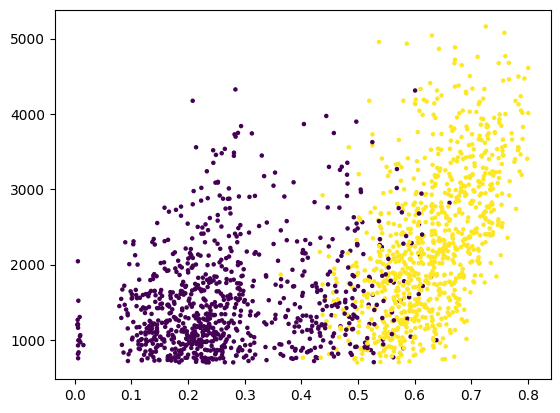

In [903]:
plt.scatter(bf_prob, val.x.closestPMT, s=5, c=val.y)
plt.show()

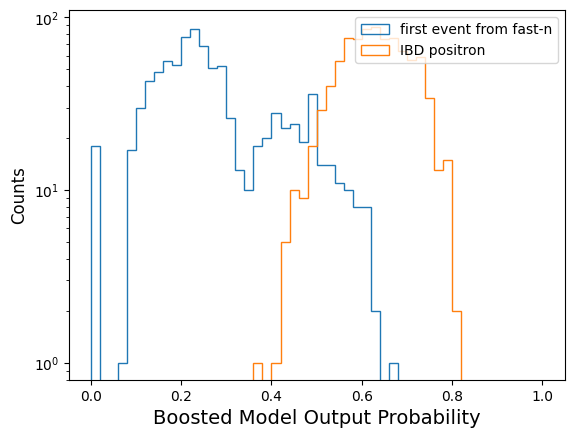

In [845]:
kw = dict(histtype='step', bins=50, range=[0,1])
plt.hist(bf_prob[val.y==0], **kw, label='first event from fast-n')
plt.hist(bf_prob[val.y==1], **kw, label='IBD positron')
plt.xlabel('Boosted Model Output Probability', fontsize=14)
plt.ylabel('Counts', fontsize=12)
plt.legend()
plt.yscale('log')
plt.show()

In [846]:
precision_recall_fscore_support(y_test, np.round(bf_scores[:,1]))

(array([0.94889663, 0.92552026]),
 array([0.92316384, 0.95050619]),
 array([0.93585338, 0.93784684]),
 array([885, 889]))

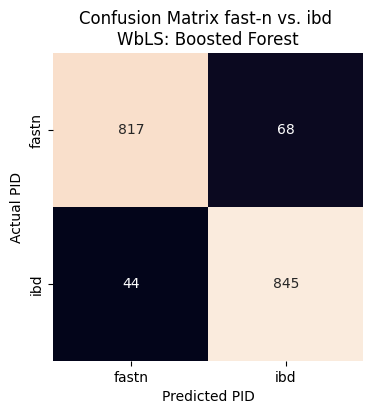

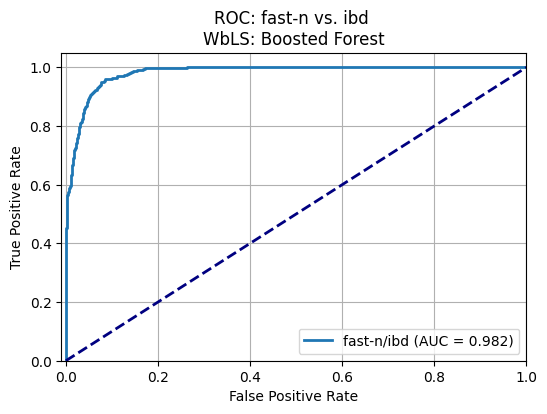

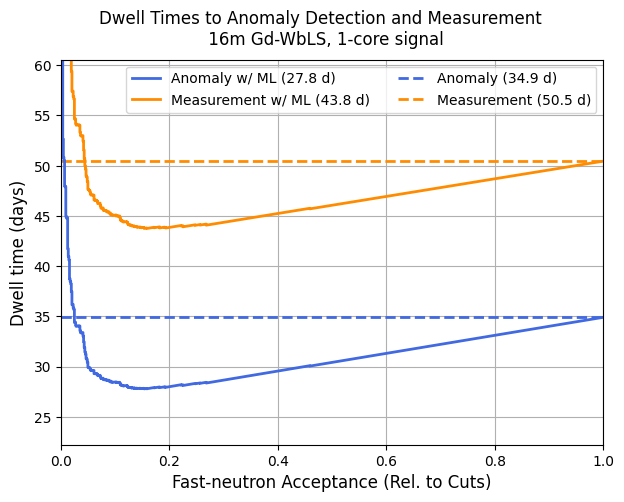

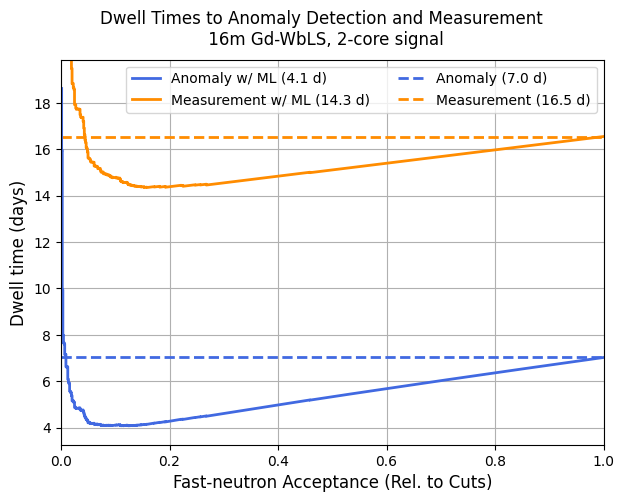

In [847]:
ml = ML_Evaluation(y_test, bf_scores)
ml.draw_confmat(extra_title='\nWbLS: Boosted Forest')
bf_tpr, bf_fpr, bf_thresholds = ml.draw_roc(extra_title='\nWbLS: Boosted Forest')
results['bf'] = dict(scores=bf_scores, tpr=bf_tpr, fpr=bf_fpr, thresholds=bf_thresholds)
bf_acceptances = dict(fpr=bf_fpr, tpr=bf_tpr)
# save_obj(acceptances, 'rates')
quick_analysis(acceptances, medium='wbls')

In [848]:
bf_feature_imp = pd.Series(bf.feature_importances_,index=dims_add).sort_values(ascending=False)

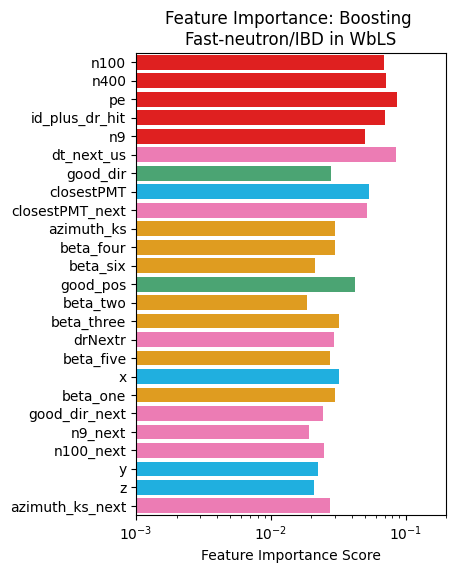

In [849]:
# Creating a bar plot
plt.figure(figsize=(4, 6))
ax = sns.barplot(x=bf_feature_imp, 
                 y=bf_feature_imp.index, order=rf_feature_imp.index,
                 palette = colors, 
                )

ax.yaxis.set_ticklabels(rf_feature_imp.index,)
# for ticklabel, tickcolor in zip(plt.gca().get_yticklabels(), colors):
#     ticklabel.set_color(tickcolor)

# ax.yaxis.set_tick_params(color=colors)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.xscale('log')
plt.xlim(1e-3, .2)
# plt.ylabel('Features')
plt.title("Feature Importance: Boosting \nFast-neutron/IBD in WbLS")
plt.show()

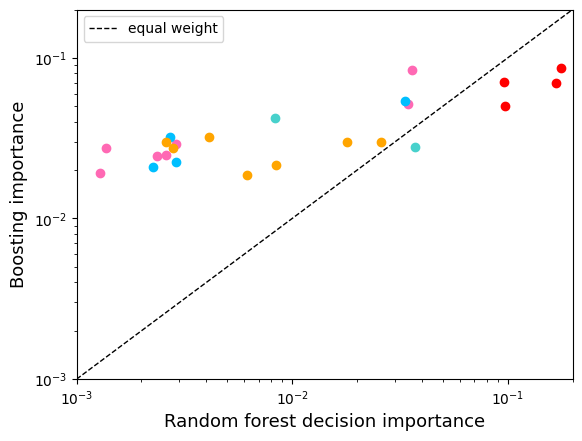

In [590]:
plt.plot(np.logspace(-3,-0.5,50), np.logspace(-3,-0.5,50), 
         c='k', lw=1, ls='--', label='equal weight')
for i, rf_ftr  in enumerate(rf_feature_imp):
    plt.scatter(rf_feature_imp[i], bf_feature_imp[rf_feature_imp.index[i]], 
                c= colors[i], 
               )
plt.ylim(1e-3, 2e-1)
plt.xlim(1e-3, 2e-1)

plt.xlabel("Random forest decision importance", fontsize=13)
plt.ylabel("Boosting importance", fontsize=13)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left', ncol=2)
plt.show()

# All methods comparison

In [850]:
methods = ['rf', 'bf', 'gcn']

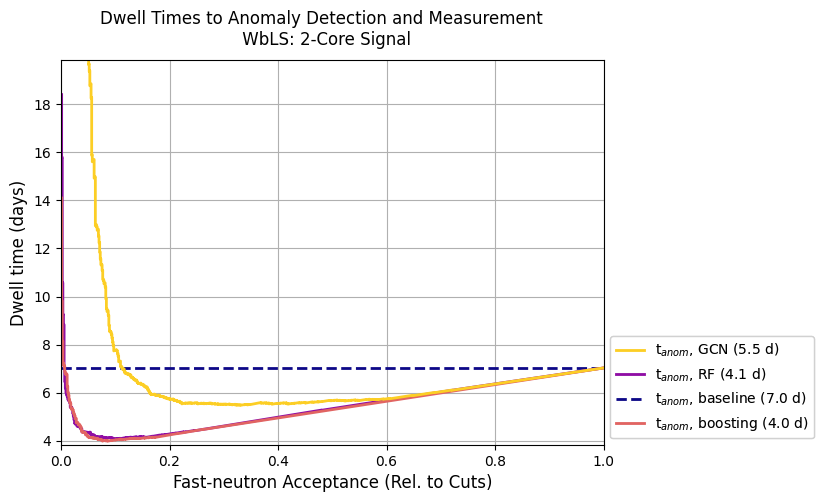

In [887]:
ncore=2
plot_times_overlay(results, 'wbls', all_rates,which_times='anom', ncore=ncore, extra_title='WbLS: %i-Core Signal'%(ncore))

In [880]:
lines=4
evenly_spaced_interval = np.linspace(0, .9, lines)
colors = [plt.cm.plasma(x) for x in evenly_spaced_interval]
colors2 = [plt.cm.winter(x) for x in evenly_spaced_interval]

methodlabels = dict(baseline='baseline', rf='RF', bf='boosting', gcn='GCN')
legendkeys =[0,1,2,3,4,5,6,7]#  [1, 5, 2, 6, 3, 7, 0, 4]

In [886]:
def plot_times_overlay(results, 
               medium, 
               all_rates, 
               ncore=1,
               extra_title='', 
               which_times='both'       
                      ):

    s0, b0 = get_s_and_b(**all_rates[medium], ncore=ncore)
    t_anom0, t_meas0 = get_times(s0, b0)
    
    fig, ax = plt.subplots(1,1, figsize=(7, 5), )
    plt.suptitle("Dwell Times to Anomaly Detection and Measurement \n %s"%(extra_title))
    ax.hlines(t_anom0, 0, 1, 
           color=colors[0], linestyle='--', lw=2, 
           label='t$_{anom}$, %s (%.1f d)'%(methodlabels['baseline'], t_anom0)
          )

    
    for m, method in enumerate(['rf','bf','gcn']):
        methodlabel=methodlabels[method]
        acceptances = results[method]
        ml_rates = ml_roc_rates(acceptances, medium, all_rates)
        s, b = get_s_and_b(**ml_rates, ncore=ncore)
        t_anom, t_meas = get_times(s, b)
    
        tpr = acceptances['tpr']
        fpr = acceptances['fpr']
        #get rid of 0-multiplication mishaps 
        mask = fpr > 0. 
        fpr, tpr = fpr[mask], tpr[mask]

        ax.plot(fpr, t_anom, 
             color=colors[m+1], lw=2, 
             label='t$_{anom}$, %s (%.1f d)'%( methodlabel, np.min(t_anom))
            )
#     if which_times=='both' or 'meas':
#         ax.plot(fpr, t_meas, 
#              color=colors2[m+1], lw=2, 
#              label='t$_{meas}$, %s (%.1f d)'%( methodlabel, np.min(t_meas))
#             )
#         ax.hlines(t_meas0, 0, 1, 
#                color=colors2[0], linestyle='--', lw=2, 
#                label='t$_{meas}$, %s (%.1f d)'%(methodlabels[0], t_meas0)
#               )
    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles, methods = zip(*sorted(zip(labels, handles, legendkeys), key=lambda t: t[0]))
    leg1 = ax.legend(handles[:4], labels[:4], bbox_to_anchor=(1., 0.3))
#     leg2 = ax.legend(handles[4:], labels[4:], bbox_to_anchor=(1., 0.8))
# pyplot.legend([l[0] for l in plot_lines], parameters, loc=4)
    plt.gca().add_artist(leg1)
#     plt.gca().add_artist(leg2)
    ax.set_xlabel('Fast-neutron Acceptance (Rel. to Cuts)', fontsize=12)
    ax.set_ylabel('Dwell time (days)', fontsize=12)    
    ax.grid()
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(min([t_anom0, min(t_anom), t_meas0, min(t_meas)])*.7,
             max([t_anom0, t_meas0])*1.2)
    plt.show()